In [1]:
#!pip install gym[mujoco]

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import torch.distributions as distributions

# Gym
import gym


## Setup the Environement

In [3]:
env_id = "Humanoid-v4"
# Create the env-
env = gym.make(env_id)

# Create the evaluation env
eval_env = gym.make(env_id)

# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.shape[0]

## Define the Model-Based Model (Env Model)

In [4]:
class Model(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(Model, self).__init__()

        # Neural network layers
        self.fc1 = nn.Linear(state_size + action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_next_state = nn.Linear(hidden_size, state_size)
        self.fc_reward = nn.Linear(hidden_size, 1)
        self.fc_done = nn.Linear(hidden_size, 1)  # New output for 'done' prediction

        self.double()


    def forward(self, state, action):
        # Concatenate state and action as input
        x = torch.cat((state, action), dim=1)

        # Forward pass through the network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        # Predict next state and reward
        next_state = self.fc_next_state(x)
        reward = self.fc_reward(x)
        done_prob = torch.sigmoid(self.fc_done(x))  # Use sigmoid to squash the output to [0, 1]

        return next_state, reward, done_prob

### Define The train_model Function for training the Model-Based Model

In [5]:
def train_model(model_optimizer, model, state, action, next_state, reward, done):
    # Convert inputs to PyTorch tensors if not already
    state = torch.tensor(state, dtype=torch.double)
    action = torch.tensor(action, dtype=torch.double)
    next_state = torch.tensor(next_state, dtype=torch.double)
    reward = torch.tensor(reward, dtype=torch.double)
    done = torch.tensor(done, dtype=torch.double)

    # Zero the gradients
    model_optimizer.zero_grad()

    # Forward pass: predict next state, reward, and done
    predicted_next_state, predicted_reward, predicted_done = model(state, action)

    # Compute the loss (e.g., mean squared error for predicted next state and reward)
    next_state_loss = F.mse_loss(predicted_next_state, next_state)
    reward_loss = F.mse_loss(predicted_reward, reward)
    done_loss = F.binary_cross_entropy(predicted_done, done)  # Binary cross entropy for 'done' prediction

    total_loss = next_state_loss + reward_loss + done_loss

    # Backward pass
    total_loss.backward()

    # Update the model parameters
    model_optimizer.step()

### Gather the Environement data by interacting with it

In [6]:
actions = []
states = []
next_states = []
rewards = []
dones = []

for i in range(33000):
    state, _ = env.reset()
    done = 0  # Initialize done as False

    while not done:
        action = env.action_space.sample()
        next_state, reward, done, _, _ = env.step(action)
        states.append(state)
        actions.append(action)
        next_states.append(next_state)
        rewards.append(reward)
        dones.append(done)

        state = next_state
        if len(dones) % 5000 == 0:
           print(len(dones))
        if len(dones) ==33000:
          break
    if len(dones) ==33000:
      break

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


5000
10000
15000
20000
25000
30000


### Train The Model-Based Model using the gathered data

C:\Users\DELL\AppData\Local\Temp\ipykernel_12608\3515353057.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  states = torch.tensor(states, dtype=torch.double).to(device)
C:\Users\DELL\AppData\Local\Temp\ipykernel_12608\2065325240.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.double)
C:\Users\DELL\AppData\Local\Temp\ipykernel_12608\2065325240.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=

Epoch 1/50, Training Loss: 581.7590, Validation Loss: 601.1636
Epoch 2/50, Training Loss: 577.5886, Validation Loss: 605.7704
Epoch 3/50, Training Loss: 531.8367, Validation Loss: 579.8612
Epoch 4/50, Training Loss: 526.5992, Validation Loss: 534.2549
Epoch 5/50, Training Loss: 506.1873, Validation Loss: 476.7390
Epoch 6/50, Training Loss: 482.0870, Validation Loss: 504.9386
Epoch 7/50, Training Loss: 469.9731, Validation Loss: 494.6928
Epoch 8/50, Training Loss: 447.5132, Validation Loss: 509.2949
Epoch 9/50, Training Loss: 424.2333, Validation Loss: 482.1858
Epoch 10/50, Training Loss: 439.4108, Validation Loss: 476.0829
Epoch 11/50, Training Loss: 413.6374, Validation Loss: 437.0284
Epoch 12/50, Training Loss: 417.1894, Validation Loss: 457.8970
Epoch 13/50, Training Loss: 377.7783, Validation Loss: 390.2152
Epoch 14/50, Training Loss: 389.6014, Validation Loss: 455.9851
Epoch 15/50, Training Loss: 416.8500, Validation Loss: 430.2939
Epoch 16/50, Training Loss: 379.5596, Validation 

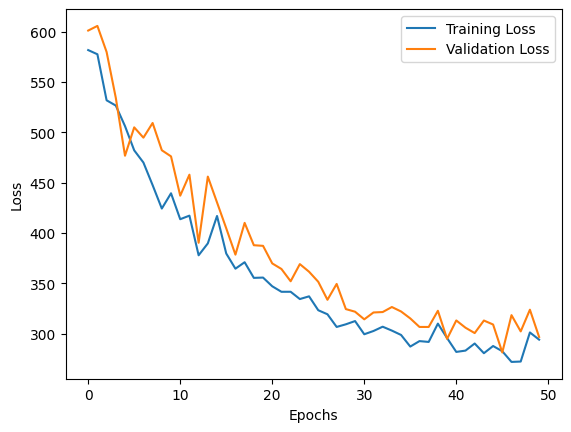

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 64
learning_rate = 1e-2
batch_size = 64
epochs = 50
# Model instantiation
model = Model(s_size, a_size, hidden_size).to(device)
model_optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Convert data to PyTorch tensors
states = torch.tensor(states, dtype=torch.double).to(device)
actions = torch.tensor(actions, dtype=torch.double).to(device)
next_states = torch.tensor(next_states, dtype=torch.double).to(device)
rewards = torch.tensor(rewards, dtype=torch.double).to(device)
# Convert done data to PyTorch tensor
dones = torch.tensor(dones, dtype=torch.double).to(device)

# Training and validation loop
history = {'train_loss': [], 'val_loss': []}

for epoch in range(epochs):
    # Shuffle the data before each epoch if needed
    indices = torch.randperm(states.size(0))
    states_shuffled = states[indices]
    actions_shuffled = actions[indices]
    next_states_shuffled = next_states[indices]
    rewards_shuffled = rewards[indices]
    dones_shuffled = dones[indices]  # Add shuffled dones

    # Split the data into training and validation sets (adjust the ratio as needed)
    split_idx = int(0.8 * len(states_shuffled))
    train_states, val_states = states_shuffled[:split_idx], states_shuffled[split_idx:]
    train_actions, val_actions = actions_shuffled[:split_idx], actions_shuffled[split_idx:]
    train_next_states, val_next_states = next_states_shuffled[:split_idx], next_states_shuffled[split_idx:]
    train_rewards, val_rewards = rewards_shuffled[:split_idx], rewards_shuffled[split_idx:]
    train_dones, val_dones = dones_shuffled[:split_idx], dones_shuffled[split_idx:]  # Add split dones

    # Train the model using the train_model function
    for i in range(0, len(train_states), batch_size):
        batch_states = train_states[i:i + batch_size]
        batch_actions = train_actions[i:i + batch_size]
        batch_next_states = train_next_states[i:i + batch_size]
        batch_rewards = train_rewards[i:i + batch_size]
        batch_dones = train_dones[i:i + batch_size]  # Add batch dones
        # Add a dummy dimension to match the size of predicted 'done'
        batch_dones = batch_dones.unsqueeze(1)
        train_model(model_optimizer, model, batch_states, batch_actions, batch_next_states, batch_rewards, batch_dones)

    # Calculate and store training loss
    with torch.no_grad():
        train_predicted_next_states, train_predicted_rewards, train_predicted_dones = model(train_states, train_actions)
        train_next_state_loss = F.mse_loss(train_predicted_next_states, train_next_states)
        train_reward_loss = F.mse_loss(train_predicted_rewards, train_rewards)
        train_done_loss = F.binary_cross_entropy(train_predicted_dones.squeeze(), train_dones)
        train_total_loss = train_next_state_loss + train_reward_loss + train_done_loss
        history['train_loss'].append(train_total_loss.item())

    # Calculate and store validation loss
    with torch.no_grad():
        val_predicted_next_states, val_predicted_rewards, val_predicted_dones = model(val_states, val_actions)
        val_next_state_loss = F.mse_loss(val_predicted_next_states, val_next_states)
        val_reward_loss = F.mse_loss(val_predicted_rewards, val_rewards)
        val_done_loss = F.binary_cross_entropy(val_predicted_dones.squeeze(), val_dones)
        val_total_loss = val_next_state_loss + val_reward_loss + val_done_loss
        history['val_loss'].append(val_total_loss.item())

    # Print the number of epochs and the training loss
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_total_loss.item():.4f}, Validation Loss: {val_total_loss.item():.4f}')

# Save the trained model if needed
torch.save(model.state_dict(), 'trained_model.pth')

# Plot the training and validation losses
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Agent: Playing MuJoCo Games 🤖
### Please Check The Gym Website for more info about the following Envs

- Walker2d
- Hopper
- Humanoid
- HumanoidStandup
- InvertedDoublePendulum

## Let's build the A2C algo


In [8]:
#Using a neural network to learn our actor (policy) parameters

class Actor(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size, dtype=torch.float32)
        self.fc2 = nn.Linear(h_size, a_size, dtype=torch.float32)
        self.double()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))  # Apply tanh activation for bounded output in [-1, 1]
        return x

    def act(self, state):
        # print('here here')
        # print(state)
        mean = self.forward(state)
        # print('mean')
        # print(mean)
        std_dev = torch.ones_like(mean)  # You might want to learn a parameter for the standard deviation as well
        # print(std_dev)
        distribution = distributions.Normal(mean, std_dev)
        # print(distribution)

        action = distribution.sample()
        # print('action')
        # print(action)
        action = torch.clamp(action, -1.0, 1.0)  # Ensure actions are within the valid range

        # print('log_prob')
        log_prob = distribution.log_prob(action)
        # print(log_prob)

        # print(log_prob)
        return torch.tensor(action), log_prob

In [9]:
#Using a neural network to learn state value
class Critic(nn.Module):

    #Takes in state
    def __init__(self, s_size, h_size):
        super(Critic, self).__init__()

        # two fully connected layers
        # add code here
        self.input_layer = nn.Linear(s_size, h_size)
        # add code here
        self.output_layer = nn.Linear(h_size, 1)
        self.double()

    def forward(self, x):

        #input layer
        x = self.input_layer(x)

        #activiation relu
        x = F.relu(x)

        #get state value
        state_value = self.output_layer(x)

        return state_value


In [10]:
def computer_cumulative_reward(rewards, max_t,gamma):
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)
        for t in range(n_steps)[::-1]:
          disc_return_t = (returns[0] if len(returns)>0 else 0)
          returns.appendleft( rewards[t]+gamma*disc_return_t)
        return returns

In [11]:
def returns_standardization(returns):
        eps = np.finfo(np.float32).eps.item()
        ## eps is the smallest representable float, which is
        # added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        return returns

In [12]:
def train_critic(criticOptimizer, returns,state_values):
        # print(11)
        state_values= torch.stack(state_values).squeeze()
        # print(12)

        critic_loss= F.mse_loss(torch.tensor(returns), state_values.squeeze())
        #critic_loss = critic_loss.float().clone()

        # print(critic_loss.dtype)

        # Backpropagate crtic
        criticOptimizer.zero_grad()
        critic_loss.backward()
        # print(14)
        criticOptimizer.step()


In [70]:
hyperparameters = {
    "h_size": 64,
    "n_training_episodes": 2000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [71]:
def train_actor(actorOptimizer,saved_log_probs, returns,state_values):


        # print('train actor ---------------------')
        #state_values = state_values
        state_values= torch.stack(state_values).squeeze()
        # print(state_values)
        #calculate Advantage for actor
        advantages = returns - state_values
        advantages = [g - val for g, val in zip(returns,state_values)]

        #convect the advantages to a tensor
        advantages = torch.Tensor(advantages).to(device)

        actor_loss = []
        # compute the actor loss
        # add code here
        # print(saved_log_probs)
        for log_prob, advantage in zip(saved_log_probs, advantages):
          actor_loss.append(-log_prob * advantage)
          # print('Adv:', advantage)
          # print('Dimensions:', log_prob.shape, advantage.shape)


        # print(actor_loss)
        # print('we are reaching this 0')
        actor_loss = torch.cat(actor_loss).sum()
        # print('we are reaching this 1')
        actorOptimizer.zero_grad()
        # print('we are reaching this 2')
        actor_loss.backward()
        # print('we are not reaching this 3')
        actorOptimizer.step()
        # print('we are not reaching this 4')

In [72]:
def generate_trajectory_mb(actor, critic, model, max_t):
        saved_log_probs = []
        rewards = []
        rewards2 = []
        state_values=[]

        state, _ = env.reset()
        # print(11)
        for t in range(max_t):
            #state=torch.from_numpy(state).float().unsqueeze(0).to(device)
            state = torch.from_numpy(state)
            if t==0:
              state = state.unsqueeze(0)



            #state = torch.from_numpy(state)
            contains_inf = torch.isinf(state).any()
            if contains_inf:
              break

            action, log_prob =  actor.act(state)

            has_nan = torch.isnan(action).any().item()
            if has_nan:
              break
            #action = torch.from_numpy(action).float().unsqueeze(0).to(device)

            # get the state value from th critic network
            state_val= critic(state)#!!!!!!!!!

            next_state, reward, done = model(state,action)
            _, reward2, done2, _, _ = env.step(action.numpy().astype(np.float32)[0])


            threshold = 0.4
            #done_sigmoid = torch.sigmoid(done)
            done = done > threshold
            next_state = next_state.detach().numpy()
            reward = reward.detach().numpy()[0]

            # add te obtained results to their relative lists ==> saved_log_probs, rewards, state_values

            # add code here
            saved_log_probs.append(log_prob.squeeze(0))
            # add code here
            rewards.append(reward[0])
            rewards2.append(reward2)
            # add code here
            state_values.append(state_val.squeeze(0))

            state=next_state
            if done | done2 :
              break

        return  saved_log_probs, rewards, rewards2, state_values

In [73]:
def Actor_Critic_mb(actor,critic, model, actorOptimizer,criticOptimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores_deque2 = deque(maxlen=100)
    scores = []
    scores2 = []

    for i_episode in range(1, n_training_episodes+1):

        # Generate an episode
        #add code here
        # print('---____----EPISODE---____----- ',i_episode)
        
        try:
            
            saved_log_probs, rewards, rewards2, state_values = generate_trajectory_mb(actor, critic, model, max_t)
        except Exception as e:
            # Code to handle other exceptions
            
            print(f"Unexpected error: {e}")
            continue
        # print(len(state_values), '------LENGTH---------')
        # print(2)
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        scores_deque2.append(sum(rewards2))
        scores2.append(sum(rewards2))
        # print('rewards')
        # print(rewards)
        # print('scores')
        # print(scores)
        # calculate the return
        returns = computer_cumulative_reward(rewards,max_t,gamma)
        # print(3)

        ## standardization of the returns is employed to make training more stable
        returns=returns_standardization(returns)

        # Train the Critic network
        #add code here
        train_critic(criticOptimizer, returns,state_values)
        # print(5)

        # Train the Actor network
        #add code here
        train_actor(actorOptimizer,saved_log_probs, returns,state_values)
        # print(6)



        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            print('Real Env Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque2)))

    return scores, scores2

In [74]:
# Create actor and place it to the device
actor = Actor(hyperparameters['state_space'],hyperparameters['action_space'],hyperparameters['h_size'])

actorOptimizer = torch.optim.Adam(actor.parameters())

In [75]:
# Create critic and place it to the device
critic = Critic(hyperparameters['state_space'],hyperparameters['h_size'])
criticOptimizer = torch.optim.Adam(critic.parameters())

In [76]:
scores_mb, scores_mb2 = Actor_Critic_mb(actor,
                   critic, model, actorOptimizer,criticOptimizer,
                   hyperparameters["n_training_episodes"],
                   hyperparameters["max_t"],
                   hyperparameters["gamma"],
                   100)

C:\Users\DELL\AppData\Local\Temp\ipykernel_12608\2916603024.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(action), log_prob
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\DELL\AppData\Local\Temp\ipykernel_12608\2860296727.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  critic_loss= F.mse_loss(torch.tensor(returns), state_values.squeeze())


Episode 100	Average Score: 88.00
Real Env Episode 100	Average Score: 89.28
Episode 200	Average Score: 152.24
Real Env Episode 200	Average Score: 157.20
Episode 300	Average Score: 189.73
Real Env Episode 300	Average Score: 193.43
Episode 400	Average Score: 211.97
Real Env Episode 400	Average Score: 219.52
Episode 500	Average Score: 222.03
Real Env Episode 500	Average Score: 225.53
Episode 600	Average Score: 219.24
Real Env Episode 600	Average Score: 220.77
Episode 700	Average Score: 212.72
Real Env Episode 700	Average Score: 213.37
Episode 800	Average Score: 196.81
Real Env Episode 800	Average Score: 198.71
Episode 900	Average Score: 227.56
Real Env Episode 900	Average Score: 228.47
Episode 1000	Average Score: 219.76
Real Env Episode 1000	Average Score: 222.20
Episode 1100	Average Score: 222.56
Real Env Episode 1100	Average Score: 221.06
Episode 1200	Average Score: 211.71
Real Env Episode 1200	Average Score: 204.48
Episode 1300	Average Score: 205.89
Real Env Episode 1300	Average Score: 

In [77]:
scores_mb= pd.Series(scores_mb, name="scores_Actor")
scores_mb.describe()

count    2000.000000
mean      206.142752
std        73.980392
min        71.088279
25%       152.983503
50%       209.719301
75%       256.392457
max       579.712133
Name: scores_Actor, dtype: float64

In [78]:
scores_mb

0       135.375022
1        75.965467
2        86.398744
3        77.780829
4        82.385667
           ...    
1995    201.173655
1996    205.365100
1997    198.888042
1998    107.224964
1999    247.391635
Name: scores_Actor, Length: 2000, dtype: float64

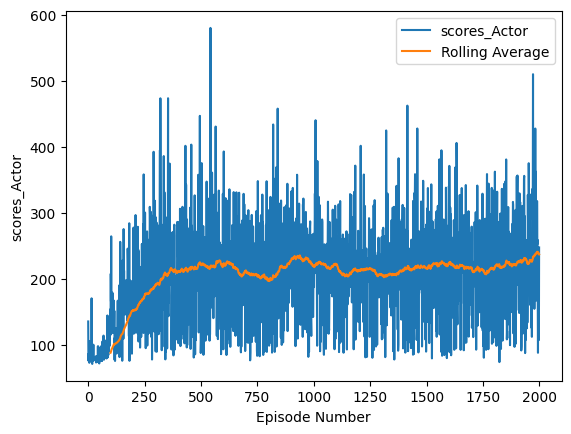

In [79]:
fig, ax = plt.subplots(1, 1)
_ = scores_mb.plot(ax=ax, label="scores_Actor")
_ = (scores_mb.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("scores_Actor")

In [80]:
scores_mb2= pd.Series(scores_mb2, name="scores_Actor")
scores_mb2.describe()

count    2000.000000
mean      206.022026
std        72.640208
min        71.513001
25%       155.472951
50%       208.035812
75%       253.458061
max       568.012021
Name: scores_Actor, dtype: float64

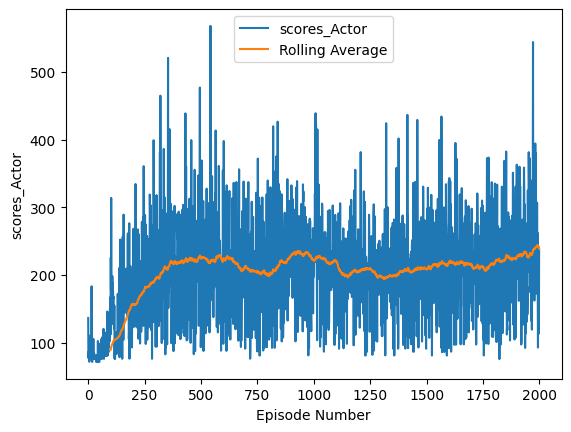

In [81]:
fig, ax = plt.subplots(1, 1)
_ = scores_mb2.plot(ax=ax, label="scores_Actor")
_ = (scores_mb2.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("scores_Actor")

In [82]:
import torch

# Assuming 'model' is your trained PyTorch model
actor_path = './'+ env_id+ '/actor.pth'
torch.save(actor, actor_path)
critic_path = './'+ env_id+ '/critic.pth'
torch.save(critic, critic_path)


In [83]:
import torch

# Assuming 'model' is your trained PyTorch model
actor_path = './'+ env_id+ '/actor_m.pth'
torch.save(actor, actor_path)
critic_path = './'+ env_id+ '/critic_m.pth'
torch.save(critic, critic_path)

In [84]:
import os
import imageio
import gym
from base64 import b64encode
from IPython.display import HTML

def generate_trajectory_with_frames(actor, critic, env, max_t):
    saved_log_probs = []
    rewards = []
    state_values = []

    state, _ = env.reset()
    frames = []  # List to store frames
    # print(11)
    for t in range(max_t):
        #state=torch.from_numpy(state).float().unsqueeze(0).to(device)
  
        if t==0:
            state = torch.from_numpy(state)
            state = state.unsqueeze(0)



        #state = torch.from_numpy(state)
        contains_inf = torch.isinf(state).any()
        if contains_inf:
            break

        action, log_prob =  actor.act(state)

        has_nan = torch.isnan(action).any().item()
        if has_nan:
            break

        action, log_prob = actor.act(state)

        # get the state value from the critic network
        state_val = critic(state)

        #next_state, reward, done, _, _ = env.step(action.numpy().astype(np.float32))
        next_state, reward, done = model(state,action)
        # print('action')
        # print(action[0])
        _, reward2, done2, _, _ = env.step(action.numpy().astype(np.float32)[0])
        frames.append(env.render())

        # add the obtained results to their relative lists ==> saved_log_probs, rewards, state_values
        saved_log_probs.append(log_prob)
        rewards.append(reward)
        state_values.append(state_val)

        state = next_state

        if done:
            break

    return saved_log_probs, rewards, state_values, frames


try:
    os.environ["DISPLAY"]
except:
    os.environ["SDL_VIDEODRIVER"] = "dummy"

env = gym.make(env_id, render_mode="rgb_array")
_, _, _, images = generate_trajectory_with_frames(actor, critic, env.unwrapped, 1000)
print(len(images))

def record_video(images, out_directory, fps=10):
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

# generate the video
for i in range(100):
    _, _, _, images = generate_trajectory_with_frames(actor, critic, env.unwrapped, 1000)
    print(len(images))
    video_path = "./"+env_id+"/"+str(len(images))+".mp4"
    record_video(images, video_path, 5)


C:\Users\DELL\AppData\Local\Temp\ipykernel_12608\2916603024.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(action), log_prob


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
